
_Written by Célia Desgrange, 2022-12-13. 
_Revised by Célia:_

In [1]:
import glob
import numpy as np
import time, os

#from astropy.convolution import (convolve_fft, convolve, Gaussian2DKernel)

#import vip_hci as vip
#from astropy.io import fits
#import cv2 

from import_functions_generic import * 
from import_functions_plotting import * 

from functions_background import *
from functions_derive_noise_map import *

#from image_manipulation import * 


In [2]:
from vip_hci.stats import frame_basic_stats
help(frame_basic_stats) []

SyntaxError: invalid syntax (1874230642.py, line 2)

In [ ]:
help(display)

In [3]:
plt.style.use('classic')  
mpl.rc('image', cmap='viridis', origin='lower')
rcParams.update({'font.size': 14,  'axes.labelsize' : 14, 'legend.fontsize' : 12,
                 "font.family": "serif", 'text.usetex' : True, "font.serif": [], "font.sans-serif": [], 'mathtext.fontset':"stix",
'legend.handlelength': 1.5, 'legend.borderaxespad' : 0.8, 'legend.columnspacing' : 1, 'legend.handletextpad' : 0.5})

In [4]:
L = time.localtime()
date = "{}-{}-{}".format(L[0],L[1],L[2],L[3],L[4],L[5])

saving_dir = 'figs/fig_v{}/'.format(date)
os.makedirs(saving_dir,exist_ok=True)

# List of observations

In [5]:
# Initialize the path to the wished data 
# -> supposed to be changed accordingly to the data/computer used
infolder = '/Users/desgranc/Documents/work/projects/HD120326/data/'
folder_prereduced = 'prereduced/convert/'
folder_reduced = 'reduced/'
dF       = pd.read_csv(infolder + 'list_obs.txt',sep='\t')
dF

,target,epoch,instrument,polar,filter,quality,"seeing ("")",tau0 (ms),delta pa (deg),PI,DIT (s),Nb frames,Total exposure (min)
0,HD_120326,2016-04-05,IRDIS,no,H23,good,1.1,3.5,37,Bonnefoy & Ménard,32.0,128.0,68.0
1,HD_120326,2016-06-03,IRDIS,no,H23,good,0.71,3.1,22,Hinkley & Matthews,32.0,80.0,43.0
2,HD_120326,2016-06-13,IRDIS,no,J23,to check,to check,to check,NaN,GTO,NaN,NaN,NaN
3,HD_120326,2018-06-01,IRDIS,yes,BB_H,very good,0.45,4.2,Boccaletti,NaN,NaN,NaN,NaN
4,HD_120326,2019-06-26,IRDIS,no,BB_H,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
5,HD_120326,2019-07-09,IRDIS,no,BB_H,very good,0.54,3.1,58,Bonnefoy & Ménard,32.0,224.0,119.0
6,HD_120326,2016-04-05,IFS,no,YJ,good,1.1,3.5,37,Bonnefoy & Ménard,64.0,64.0,68.0
7,HD_120326,2016-06-03,IFS,no,YJ,good,0.71,3.1,22,Hinkley & Matthews,64.0,40.0,43.0
8,HD_120326,2019-06-26,IFS,no,YJ,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
9,HD_120326,2019-07-09,IFS,no,YJ,very good,0.54,3.1,58,Bonnefoy & Ménard,64.0,112.0,119.0


## General parameters

In [6]:
# cmaps
cmap_dark_red =  seaborn.blend_palette([[1,0,0],'crimson','firebrick','darkred',[0.3,0,0]], as_cmap=True)
cmap_red = seaborn.blend_palette(['white',[1,0.95,0],'orange', 'red'], as_cmap=True)
cmap_orange = seaborn.blend_palette(['white',[1,0.95,0],'gold'], as_cmap=True)
cmap_pinkish = seaborn.blend_palette(['white',[1,0.5,1],'purple', 'blue'], as_cmap=True)
cmap_pink = seaborn.blend_palette(['white',[1,0.4,1],[0.8,0,0.7],[0.75,0,0.7]], as_cmap=True)
cmap_blue = seaborn.blend_palette(['white',[0.5,0.9,1], [0,0.5,1],  [0,0,1]], as_cmap=True)
cmap_blue_light = seaborn.blend_palette(['white',[0.5,0.9,1], [0,0.5,1]], as_cmap=True)
cmap_white = seaborn.blend_palette(['white', 'ivory'], as_cmap=True)
cmap = cmap_white

list_rainbow = ['blue','skyblue','hotpink', 'purple','gold','red','orange']
colors_rainbow = seaborn.blend_palette(list_rainbow,7)
display(colors_rainbow)

MARKERS_IFS = ['<','>','<','>','D','D','o']
COLORS_IFS = colors_rainbow

[(0.0, 0.0, 1.0),
 (0.5231833910034602, 0.7983391003460208, 0.9224913494809688),
 (1.0, 0.4117647058823529, 0.7058823529411765),
 (0.5078200692041522, 0.00991926182237601, 0.4960553633217993),
 (1.0, 0.8431372549019608, 0.0),
 (1.0, 0.007612456747405272, 0.0),
 (1.0, 0.6470588235294118, 0.0)]

In [9]:
# Image - observation
pixel_scale=0.01225 # pixel scale in arcsec/px 
platescale = pixel_scale*1e3
scalebar_pix, scalebar_leg = 1000, '1"'
nx = 624 # number of pixels of your image in X
ny = 624 # number of pixels of your image in Y

# Save file .fits
writeto = False # save .fits file

# Figure
add_colorbar=0
figsize_rectange, figsize_square  = (4,3), (3,3)
figsize = np.where(add_colorbar, figsize_rectange, figsize_square)
left, right = 0.01, float(np.where(add_colorbar, 0.78, 0.99))
top, bottom = float(np.where(add_colorbar, 0.95, 0.99)), float(np.where(add_colorbar, 0.05, 0.01))
im_crop = 250
save_png = 1    # save .png file
cbar_xdeb = 0.83
scalebar_pix, scalebar_leg = 100, '0.1"'

text_xfrac, text_yfrac = 0.03, 0.84
filt='H'

# IFS

## Parameters

In [11]:
im_crop_PCA = 8 #9 #im_crop_PCA
im_crop_mask = 8

## MASK

In [12]:
folder_mask = '/Users/desgranc/Documents/work/GitHub_clone/projects/HD102326/grater_diskfm_mcmc/inputs/'
fn_mask = 'mask_inner_belt_2019-07-09_IFS.fits'
path_mask = folder_mask + fn_mask
im_mask_ifs = fits.getdata(path_mask)
np.shape(im_mask_ifs)

(240, 240)

Size of the image = 240 and crop Mask = 8 i.e. size of the image shown = 224
The file is saved here:
 figs/fig_v2023-5-22/im_mask_inner_belt_2019-07-09_IFS


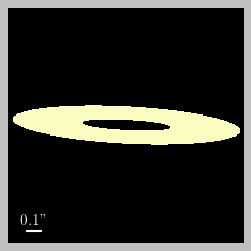

In [13]:
namesave = 'im_{}'.format(fn_mask.replace('.fits',''))
im = np.copy(im_mask_ifs)
im_crop = im_crop_mask

print('Size of the image =', len(im), 'and crop Mask =', im_crop_mask, 'i.e. size of the image shown =',  
      len(im_mask_ifs)-2*im_crop_mask)

clab = 'contrast'
vmin, vmax = None, None
text = ''#'{} {}\n{}'.format(epoch, filt, algo)
#text = '{} {} (total intensity)\n{}'.format(epoch, filt.replace('BB_',''), algo)


plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, figsize=figsize,
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         right=right, left=left, top=top, bottom=bottom,
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

## Load the data to derive the NOISE (error bars)

In [61]:
# REDUCED DATA
idx, before_or_after,sorting,channel = 9,  '*', 'sorting','*'
epoch = str(dF['epoch'].iloc[idx]); instru=str(dF['instrument'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
filt =  str(dF['filter'].iloc[idx])
if filt == 'BB_H': filt = 'BBH'  
algo = 'PCA'
algo_folder = algo + '_Celia/fits/OPP_PA/'
if instru == 'IFS': platescale=7.46

path_im_reduced = infolder + folder_reduced + algo_folder + '*{}*{}*indiv*{}*{}*{}_cube_im_pca.fits'.format(epoch, instru,
                                            before_or_after,sorting,channel)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
flist = np.sort(flist)
LABELS=[]
for f in flist: 
    print('-',f)
    band = select_string_between_characs(f,'_','_',2)
    f_backup = f
CUBE_REDUCED = np.array( [ fits.getdata(flist[i]) for i in range(len(flist)) ] )


Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/OPP_PA/*2019-07-09*IFS*indiv***sorting**_cube_im_pca.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/OPP_PA/2019-07-09_IFS_YJ_indiv_both_channels_combine_after_Nonesorting_cube_im_pca.fits


In [53]:
# OPP PA
namesave= ''
cube = np.copy(CUBE_REDUCED)[0]
im_crop = im_crop_PCA

cube = cube[:,im_crop:-im_crop,im_crop:-im_crop] 

# Define a circular mask center at one given location (xloc,yloc)
xloc, yloc = 89-im_crop,113-im_crop; rcut=3
im_loc = compute_im_rad_grid_coord(np.copy(cube[0]), xloc, yloc)
im_loc = np.where(im_loc<rcut, 1, 0) 
cube = np.copy(cube)*im_loc

cond = cube > 0
cube[~cond] = np.nan
nb_pix_used = len(im_loc[im_loc==1])
flux = np.nansum(cube, axis=(1,2)) / nb_pix_used 
std = np.nanstd(cube, axis=(1,2)) #/ nb_pix_used 
print('Number of pixels considered:', nb_pix_used)
#print(np.shape(flux))
#print(flux)

-81 143
Number of pixels considered: 25


No handles with labels found to put in legend.


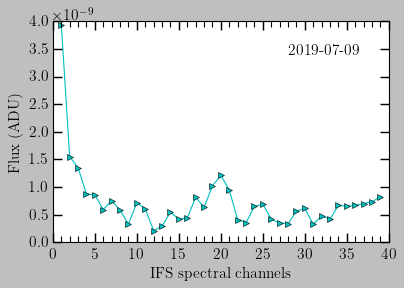

In [62]:
# Figure spectrum OPP PA
namesave='spectra_flux_{}_{}_all_channels_mask_circular_opp_pa.pdf'.format(epoch, instru)

norm = Y_star

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(left=0.12,right=0.96,bottom=0.14,top=0.93)
X = np.arange(1,40,1)
ax.set_xlabel('IFS spectral channels')
ax.set_ylabel('Flux (ADU)')

text = '{}'.format(epoch, filt)
ax.text(0.7,0.85,text, transform=ax.transAxes)
ax.plot(X,flux/norm,marker=MARKERS_IFS[3],label='', color='c')

mise_en_page(ax,x_step=1, x_maj_step=5, x_min_step=1, y_step=0, y_maj_step=0.5, y_min_step=0.1)
#plt.ylim([0,1])
ax.legend(loc='best', numpoints=1, ncol=2, frameon=False)

plt.savefig(saving_dir+namesave)
plt.show()

# Load the SCIENCE data

In [55]:
# REDUCED DATA
idx, before_or_after,sorting,channel = 9,  '*', 'sorting','*'
epoch = str(dF['epoch'].iloc[idx]); instru=str(dF['instrument'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
filt =  str(dF['filter'].iloc[idx])
if filt == 'BB_H': filt = 'BBH'
if filt == 'H23': filt = 'H23'    
algo = 'PCA'
algo_folder = algo + '_Celia/fits/SCIENCE/'
if instru == 'IFS': platescale=7.46

path_im_reduced = infolder + folder_reduced + algo_folder + '*{}*{}*indiv*{}*{}*{}_cube_im_pca.fits'.format(epoch, instru,
                                            before_or_after,sorting,channel)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
flist = np.sort(flist)
LABELS=[]
for f in flist: 
    print('-',f)
    band = select_string_between_characs(f,'_','_',2)
    f_backup = f
CUBE_REDUCED = np.array( [ fits.getdata(flist[i]) for i in range(len(flist)) ] )


Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/*2019-07-09*IFS*indiv***sorting**_cube_im_pca.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/2019-07-09_IFS_YJ_indiv_both_channels_combine_after_Nonesorting_cube_im_pca.fits


In [38]:
# PSF
print('- PSF -')
path_im_prereduced = infolder + folder_prereduced + instru + '/*{}*/'.format(epoch) + '*median_unsat.fits'
        
print('It corresponds do the path:\n{}'.format(path_im_prereduced))
print('Files found:')
flist = glob(path_im_prereduced)
for f in flist: print('-',f)
im_prereduced = fits.getdata(flist[0])

print('Shape of the PSF', np.shape(im_prereduced))

# Wavelength grids
print('\n - Wavelength grid -')
path_im_prereduced = infolder + folder_prereduced + instru + '/*{}*/'.format(epoch) + '*lam.fits'
        
#print('It corresponds do the path:\n{}'.format(path_im_prereduced))
print('Files found:')
flist = glob(path_im_prereduced)
for f in flist: print('-',f)
wgrid = fits.getdata(flist[0])

- PSF -
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/prereduced/convert/IFS/*2019-07-09*/*median_unsat.fits
Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/prereduced/convert/IFS/HIP 67497_OBS_YJ_2019-07-09_ifs_convert_dc2_PUBLIC_357580/ifs_convert_dc2-IFS_SCIENCE_PSF_MASTER_CUBE-median_unsat.fits
Shape of the PSF (39, 2, 64, 64)

 - Wavelength grid -
Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/prereduced/convert/IFS/HIP 67497_OBS_YJ_2019-07-09_ifs_convert_dc2_PUBLIC_357580/ifs_convert_dc2-IFS_SCIENCE_LAMBDA_INFO-lam.fits


In [39]:
from functions_derive_noise_map import *


#### Check the PSF

/Users/desgranc/Documents/work/GitHub_clone/main_scripts/functions_derive_noise_map.py:114: RuntimeWarning: Mean of empty slice
  noise_annulus = np.nanmean(im_annulus)
/Users/desgranc/Documents/work/GitHub_clone/main_scripts/functions_derive_noise_map.py:114: RuntimeWarning: Mean of empty slice
  noise_annulus = np.nanmean(im_annulus)


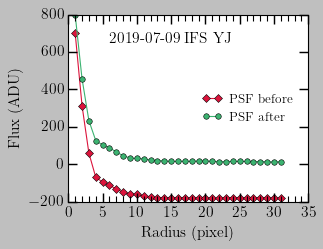

In [40]:
figsize = (4,3)
# Check the PSF
# Radial Profile
im = np.copy(im_prereduced)[0][0]
profile_mean, separations = rad_profile(im, center=np.shape(im)[0]//2, mode='mean', pixscale=platescale*1e-3, skip_pix=1)

# Figure
fig, ax = plt.subplots(1,1,figsize=figsize)
fig.subplots_adjust(left=0.2,right=0.95, top=0.95, bottom=0.17)

# PSF before
im = np.copy(im_prereduced)[0][0]
profile_mean, separations = rad_profile(im, center=np.shape(im)[0]//2, mode='mean', pixscale=platescale*1e-3, skip_pix=1)
ax.plot(separations/platescale*1e3, profile_mean, color='crimson',marker='D', ms=5, label='PSF before')
# PSF after
im = np.copy(im_prereduced)[0][1]
profile_mean, separations = rad_profile(im, center=np.shape(im)[0]//2, mode='mean', pixscale=platescale*1e-3, skip_pix=1)
ax.plot(separations/platescale*1e3, profile_mean, color='mediumseagreen',marker='o', ms=5, label='PSF after')


ax.set_xlabel('Radius (pixel)')
ax.set_ylabel('Flux (ADU)')

ax.legend(frameon=False, loc='center right')

text = '{} {} {}'.format(epoch, instru, filt.replace('_',''))
ax.text(0.17,0.85,text,transform=ax.transAxes)

namesave = 'radial_profile_flux_'+epoch+'_'+instru.replace(' ','_')
mise_en_page(ax, x_step=1, x_maj_step=5, x_min_step=1)
plt.savefig(saving_dir+namesave+'.pdf')


In [25]:
# Select only one PSF
if epoch == '2019-07-09': im_prereduced=im_prereduced[:,1] # The PSF after is the good one

In [26]:
# Mask regions
r_star = 24
r_bkg_in = 25
r_bkg_out = 30
im_crop = 0

# Figure
color_star, color_bkg = 'gold', [0,0,0.3]; color_bkg_lighter='royalblue'
ms_star, ms_bkg = 7,5

color_scalebar='black'
color_text='black'
#platescale=7.46

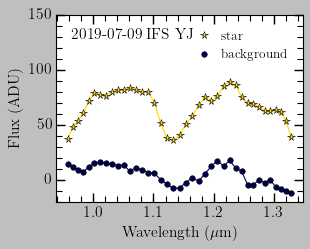

In [27]:
# Plot PSF flux
# Figure Flux as the spectral channel
figsize = (4,3)
nlbd = np.shape(im_prereduced)[0]

fig, ax = plt.subplots(1,1,figsize=figsize)
fig.subplots_adjust(left=0.2,bottom=0.17, top=0.95, right=0.97)
norm = 1e3

# Several PSFs
if len(np.shape(im_prereduced)) == 4:
    for i in range(np.shape(im_prereduced)[1]):
        #if i == 1 : continue
        im_i = np.copy(im_prereduced[:,i])#/norm
        if i == 1:
            Y_star, Y_bkg = shortcut_plot_flux_star_and_background(ax, im_i, r_star=r_star, r_bkg_in=r_bkg_in, r_bkg_out=r_bkg_out, 
                    ms_star=ms_star, ms_bkg=ms_bkg, color_star='w', color_bkg='w', return_flux=1,
                    do_norm=1, give_X=1, X=wgrid, display=0)
        else: 
            Y_star, Y_bkg = shortcut_plot_flux_star_and_background(ax, im_i, r_star=r_star, r_bkg_in=r_bkg_in, r_bkg_out=r_bkg_out, 
                    ms_star=ms_star, ms_bkg=ms_bkg, color_star=color_star, color_bkg=color_bkg,  return_flux=1,
                    do_norm=1, give_X=1, X=wgrid, display=0)
        
# One PSF
if len(np.shape(im_prereduced)) == 3:
    Y_star, Y_bkg = shortcut_plot_flux_star_and_background(ax, im_prereduced, r_star=r_star, r_bkg_in=r_bkg_in, r_bkg_out=r_bkg_out,
            ms_star=ms_star, ms_bkg=ms_bkg, color_star=color_star, color_bkg=color_bkg, do_norm=1,  return_flux=1,
            give_X=1, X=wgrid, display=0)
    
# Add labels
ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel(r'Flux (ADU)')

# Change size
if epoch == '2019-07-09':
    #ax.set_xlim([0, nlbd+1])
    #ax.set_ylim([-3e5/norm, 6e5/norm])
    loc='upper right'
    if r_star < 6 : ax.set_ylim([-500, 2500]); y_maj_step=500; y_min_step=100
    else: ax.set_ylim([-20, 150]); y_maj_step=50; y_min_step=10
if epoch == '2016-04-05':
    #ax.set_xlim([0, nlbd+1])
    if r_star < 6 : ax.set_ylim([0, 2500])
    else: ax.set_ylim([0, 400]); y_maj_step=100; y_min_step=20
    loc='upper right'
if epoch == '2016-06-03':
    #ax.set_xlim([0, nlbd+1])
    if r_star < 6 : ax.set_ylim([0, 2000]); loc='lower right'
    else: ax.set_ylim([0, 150]); loc='upper right'; y_maj_step=50; y_min_step=10
    
#ax.set_yscale('log')
ax.set_xlim([wgrid[0]-wgrid[0]*0.02,wgrid[-1]+wgrid[0]*0.02])

# Add text
text = '{} {} {}'.format(epoch, instru, filt.replace('_',''))
ax.text(0.06,0.87,text,transform=ax.transAxes)

# Add legend
ax.plot([-10],[0], marker='*', ms=7, label= 'star', lw=0, color='gold')
ax.plot([-10],[0], marker='o', ms=5, label= 'background', lw=0, color=[0,0,0.4])
ax.legend(loc=loc, numpoints=1, frameon=False)
# Save
if r_star < 6 :
    mise_en_page(ax, x_step=1, x_maj_step=5, x_min_step=1, y_step=1, y_maj_step=500, y_min_step=100)
mise_en_page(ax, x_step=1, x_maj_step=0.1, x_min_step=0.02, y_step=1, y_maj_step=y_maj_step, y_min_step=y_min_step) 
namesave = 'check_star_and_bkgd_flux_'+text.replace(' ','_')
plt.savefig(saving_dir+namesave+'.pdf')
plt.show()

### Mosaic of the IFS channels
to come

## Spectra

##### Mask = all disk region

#### Derive the spectra

In [56]:
# SCIENCE
namesave= ''
cube = np.copy(CUBE_REDUCED)[0]
im_crop = im_crop_PCA
print('Size of the cube =', np.shape(cube), 'and crop PCA =', im_crop, 'i.e. size of the image shown =',  np.shape(cube)[-1]-2*im_crop)
print('Size of the mask =', np.shape(im_mask_ifs), 'and crop MASK =', im_crop_mask, 
      'i.e. size of the image shown =',  np.shape(im_mask_ifs)[-1]-2*im_crop_mask)

im_mask_cropped = np.copy(im_mask_ifs[im_crop_mask:-im_crop_mask,im_crop_mask:-im_crop_mask])

cube = cube[:,im_crop:-im_crop,im_crop:-im_crop] * im_mask_cropped 

cond = cube>0
cube[~cond] = np.nan
nb_pix_used = len(im_mask_cropped[im_mask_cropped==1])
flux = np.nansum(cube, axis=(1,2)) / nb_pix_used 
std = np.nanstd(cube, axis=(1,2)) #/ nb_pix_used 
print('Number of pixels considered:', nb_pix_used)
np.shape(flux)

Size of the cube = (39, 240, 240) and crop PCA = 8 i.e. size of the image shown = 224
Size of the mask = (240, 240) and crop MASK = 8 i.e. size of the image shown = 224
Number of pixels considered: 5368


(39,)

No handles with labels found to put in legend.


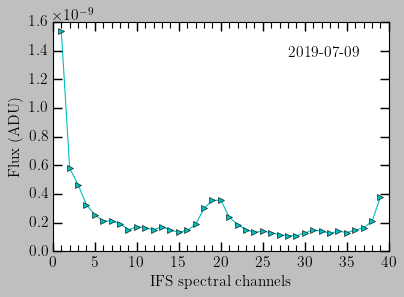

In [51]:
# Figure spectrum
namesave='spectra_flux_{}_{}_all_channels_mask_disk_science.pdf'.format(epoch, instru)

norm = Y_star

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(left=0.12,right=0.96,bottom=0.14,top=0.96)
X = np.arange(1,40,1)
ax.set_xlabel('IFS spectral channels')
ax.set_ylabel('Flux (ADU)')

text = '{}'.format(epoch, filt)
ax.text(0.7,0.85,text, transform=ax.transAxes)
ax.plot(X,flux/norm,marker=MARKERS_IFS[3],label='', color='c')

mise_en_page(ax,x_step=1, x_maj_step=5, x_min_step=1, y_step=0, y_maj_step=0.5, y_min_step=0.1)
#plt.ylim([0,1])
ax.legend(loc='best', numpoints=1, ncol=2, frameon=False)

plt.savefig(saving_dir+namesave)
plt.show()

#### Contrast

No handles with labels found to put in legend.


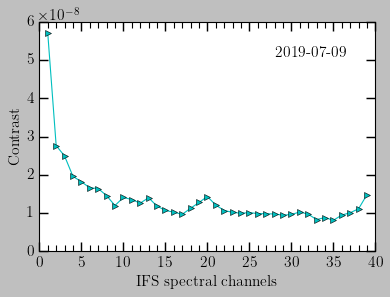

In [50]:
# Figure spectrum
namesave='spectra_contrast_{}_{}_all_channels_mask_disk_science.pdf'.format(epoch, instru)

norm = 1# Y_star

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(left=0.12,right=0.96,bottom=0.14,top=0.96)
X = np.arange(1,40,1)
ax.set_xlabel('IFS spectral channels')
ax.set_ylabel('Contrast')

text = '{}'.format(epoch, filt)
ax.text(0.7,0.85,text, transform=ax.transAxes)
ax.plot(X,flux/norm,marker=MARKERS_IFS[3],label='', color='c')

mise_en_page(ax,x_step=1, x_maj_step=5, x_min_step=1, y_step=0, y_maj_step=0.5, y_min_step=0.1)
#plt.ylim([0,1])
ax.legend(loc='best', numpoints=1, ncol=2, frameon=False)

plt.savefig(saving_dir+namesave)
plt.show()

##### Mask =  small aperture on the disk region  
#### Derive the spectra

In [57]:
# SCIENCE 
namesave= ''
cube = np.copy(CUBE_REDUCED)[0]
im_crop = im_crop_PCA

cube = cube[:,im_crop:-im_crop,im_crop:-im_crop] 

# Define a circular mask center at one given location (xloc,yloc)
xloc, yloc = 89-im_crop,113-im_crop; rcut=3
im_loc = compute_im_rad_grid_coord(np.copy(cube[0]), xloc, yloc)
im_loc = np.where(im_loc<rcut, 1, 0) 
cube = np.copy(cube)*im_loc

cond = cube > 0
cube[~cond] = np.nan
nb_pix_used = len(im_loc[im_loc==1])
flux = np.nansum(cube, axis=(1,2)) / nb_pix_used 
std = np.nanstd(cube, axis=(1,2)) #/ nb_pix_used 
print('Number of pixels considered:', nb_pix_used)
#print(np.shape(flux))
#print(flux)

-81 143
Number of pixels considered: 25


#### Flux (ADU)

No handles with labels found to put in legend.


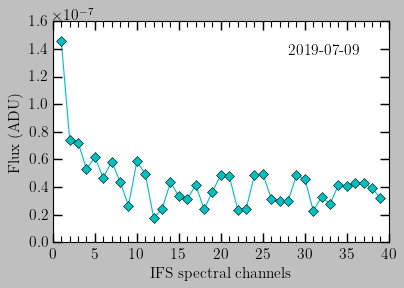

In [60]:
# Figure spectrum (flux)
namesave='spectra_flux_{}_{}_all_channels_mask_circular_science.pdf'.format(epoch, instru)

norm = 1#Y_star

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(left=0.12,right=0.96,bottom=0.14,top=0.93)
X = np.arange(1,40,1)
ax.set_xlabel('IFS spectral channels')
ax.set_ylabel('Flux (ADU)')

text = '{}'.format(epoch, filt)
ax.text(0.7,0.85,text, transform=ax.transAxes)
ax.plot(X,flux/norm,marker=MARKERS_IFS[4],label='', color='c')

mise_en_page(ax,x_step=1, x_maj_step=5, x_min_step=1, y_step=0, y_maj_step=0.5, y_min_step=0.1)
#plt.ylim([0,1])
ax.legend(loc='best', numpoints=1, ncol=2, frameon=False)

plt.savefig(saving_dir+namesave)
plt.show() 

In [17]:
help(Axes.set_label)

Help on function set_label in module matplotlib.artist:

set_label(self, s)
    Set a label that will be displayed in the legend.
    
    Parameters
    ----------
    s : object
        *s* will be converted to a string by calling `str`.



#### Contrast

No handles with labels found to put in legend.


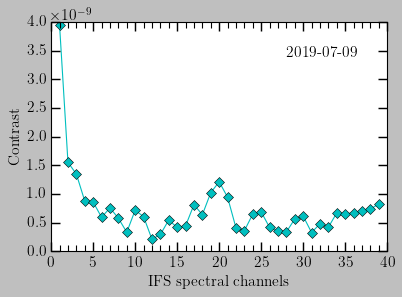

In [33]:
# Figure spectrum (contrast)
namesave='spectra_contrast_{}_{}_all_channels_mask_circular.pdf'.format(epoch, instru)

norm = Y_star 

fig, ax = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(left=0.12,right=0.96,bottom=0.14,top=0.96)
X = np.arange(1,40,1)
ax.set_xlabel('IFS spectral channels')
ax.set_ylabel('Contrast')

text = '{}'.format(epoch, filt)
ax.text(0.7,0.85,text, transform=ax.transAxes)
ax.plot(X,flux/norm,marker=MARKERS_IFS[4],label='', color='c')

mise_en_page(ax,x_step=1, x_maj_step=5, x_min_step=1, y_step=0, y_maj_step=0.5, y_min_step=0.1)
#plt.ylim([0,1])
ax.legend(loc='best', numpoints=1, ncol=2, frameon=False)

plt.savefig(saving_dir+namesave)
plt.show()

## Binning

In [34]:
writeto=1

Shape before binning: (39, 240, 240) after binning: (4, 240, 240)
Shape before binning: (39, 64, 64) after binning: (4, 64, 64)


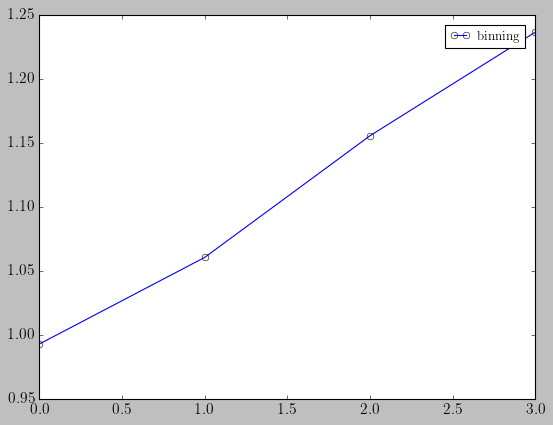

File saved under the name:
 /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/2019-07-09_IFS_YJ_indiv_both_channels_combine_after_Nonesorting_cube_im_pca_binning=7channels_2-36_skipping18-20


In [255]:
# Initialization
wgrid_bin = []
cube_reduced_bin = []
im_prereduced_bin = []
channels = np.arange(39)
nw_nominal = len(wgrid)

# Wavelength binning selection
w_skip_beg, w_skip_end = 17, 20
channels_used = np.concatenate((channels[:w_skip_beg], channels[w_skip_end:]))
wgrid_used = np.concatenate((wgrid[:w_skip_beg], wgrid[w_skip_end:]))
cube_reduced_used = np.concatenate((cube_reduced[:w_skip_beg], cube_reduced[w_skip_end:]))
im_prereduced_used = np.concatenate((im_prereduced[:w_skip_beg], im_prereduced[w_skip_end:]))

dw, nw = 7, len(wgrid_used)
w_beg, w_end, w_end_norminal = 1, nw-1, nw_nominal-1
x = []

cube_reduced = np.copy(CUBE_REDUCED)[0]
for i in range(w_beg, w_end, dw):
    if i+dw >= nw : continue # if we do not have 'dw' channels to bin them at the end, we forget them
    wgrid_bin.append( np.mean(wgrid_used[i:i+dw]) ) 
    cube_reduced_bin.append( np.nanmean(cube_reduced_used[i:i+dw], axis=0) )
    im_prereduced_bin.append( np.nanmean(im_prereduced_used[i:i+dw], axis=0) )
    x.append(i+0.5)

wgrid_bin,  cube_reduced_bin, im_prereduced_bin = np.array(wgrid_bin), np.array(cube_reduced_bin),  np.array(im_prereduced_bin)
                                     
                                     
print('Shape before binning:', np.shape(cube_reduced), 'after binning:', np.shape(cube_reduced_bin) )
print('Shape before binning:', np.shape(im_prereduced),'after binning:', np.shape(im_prereduced_bin))

if 1:
    plt.plot(wgrid_bin,label='binning',marker='o',mfc='None')
    #plt.plot(np.arange(0,nw,1), wgrid, label='nominal',marker='s')
    plt.legend()
    plt.show()

suffix = '_binning={}channels_{}-{}_skipping{}-{}'.format(dw, w_beg+1, w_end+1, w_skip_beg+1, w_skip_end)
namesave = f_backup[:-5] + suffix


if writeto:
    print('File saved under the name:\n', namesave)
    fits.writeto(namesave+'.fits', cube_reduced_bin, overwrite=True)
    fits.writeto('cube'+suffix+'.fits', cube_reduced_bin, overwrite=True)

    fits.writeto(namesave+'_lbd.fits', wgrid_bin, overwrite=True)
    fits.writeto('cube'+suffix+'_lbd.fits', wgrid_bin, overwrite=True)


1.32884

In [225]:
channels_used

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38])

In [168]:
np.shape( np.nanmean(cube_reduced[i:i+dw], axis=0))

(240, 240)

In [20]:
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels)
    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]




In [23]:
# Figure
if 0 :
    namesave='snr_wrt_ncomp_{}_{}_4collapse.pdf'.format(epoch, instru)
 
    fig, ax = plt.subplots(1,1, figsize=(5,3.5))
    fig.subplots_adjust(left=0.12,right=0.96,bottom=0.14,top=0.96)
    X = np.arange(1,21,1)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('$S/N$')

    text = '{}'.format(epoch, filt)
    ax.text(15,0.1,text)

    for i in range(4):
        ax.plot(X,snr[i],marker=MARKERS_IFS[i],label=LABELS[i], color=COLORS_IFS[i])
        #ax.errorbar(X,snr[i], std[i], 0, marker='o',label=LABELS[i])
    mise_en_page(ax,x_step=1, x_maj_step=5, x_min_step=1)
    plt.ylim([0,1])

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    #reorderLegend(ax,LABELS)

    ax.legend(loc='best', numpoints=1, ncol=2, frameon=False)


    plt.savefig(saving_dir+namesave)
    plt.show()

In [30]:

def plot_figs_1row(IM, TIT=['','','','','',''], clab='', vmin=None, vmax=None, add_text=0, text=['','','','','',''],
                   text_xfrac=None, text_yfrac=None,
                   scalebar_pix=100, scalebar_leg='100 mas', platescale=12.25,
                   show_axis_ticks='off', cbar_xdeb=0.82, right=0.8, top=0.95, left=0.01, bottom=0.05, wspace=0.01,
                   figsize_height=4, figsize=(None,None), fig=None, axs=None,
                   cmap='magma', add_colorbar=1,
                    im_crop=0, interpolation='nearest', 
                   give_fig_ax=0, return_fig_ax=0, saving_dir='', namesave='test', save_png=0):
    nco = len(IM)
    if not give_fig_ax: 
        if figsize == (None,None): figsize=(figsize_height*nco+1,figsize_height)
        fig, axs = plt.subplots(1,nco, figsize=figsize)
    fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom, wspace=wspace)

    for i, im in enumerate(IM):
        ax = axs[i]
        ax.axis(show_axis_ticks)
        tit = TIT[i]
        ax.set_title(tit)
        if im_crop != 0: im = im[im_crop:-im_crop,im_crop:-im_crop]
        if vmin != None and vmax != None: im_plot = ax.imshow(im, vmin=vmin, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap)
        elif vmax != None : im_plot = ax.imshow(im, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap)
        elif vmin != None : im_plot = ax.imshow(im, vmin=vmin, origin='lower', interpolation=interpolation, cmap=cmap)
        else : im_plot = ax.imshow(im, origin='lower', interpolation=interpolation, cmap=cmap)

        # Add text
        w,h = np.shape(im)
        if add_text:
            # One same text to add on every subimage
            if len(text[0]) == 1: t = text
            # Different texts to add on every subimages
            else: t=text[i]
            if text_xfrac == None: text_xfrac = w*0.03
            if text_yfrac == None: text_yfrac = h*0.94
            ax.text(text_xfrac,text_yfrac,t,color='white')

        # Add scalebar
        scalebar = AnchoredSizeBar(ax.transData, scalebar_pix/platescale, scalebar_leg, 3, label_top=True, pad=0.4,
                                   sep=2, borderpad=0.5, frameon=False, size_vertical=2, color='white')#,fontproperties=fp)
        ax.add_artist(scalebar)

    # Add colorbar
    if add_colorbar:
        cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth, clab = cbar_xdeb,  bottom, w*3e-5, top-bottom, clab
        cb_ax = fig.add_axes([cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth])

        cbar = fig.colorbar(im_plot, cax=cb_ax, orientation='vertical', #drawedges=True,
                        pad=0.8, shrink=0.05,fraction=0.01,aspect=50)#,width_fraction=0.001)

        cbar.set_label(clab)
    print('The file is saved here:\n', saving_dir+namesave)
    if return_fig_ax: return fig, axs
    else: 
        if namesave != '':
            plt.savefig(saving_dir+namesave+'.pdf')
            if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
    plt.show()



The file is saved here:
 figs/fig_v2023-4-11/


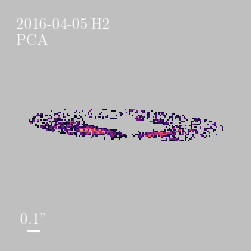

In [196]:
# Check Figure
clab = 'contrast'
vmin, vmax = None, None
text = '{} {}\n{}'.format(epoch, filt, algo)
#text = '{} {} (total intensity)\n{}'.format(epoch, filt.replace('BB_',''), algo)

# Figure
plot_fig(im=cube[3,5], vmin=vmin, vmax=vmax, im_crop=0, figsize=figsize,
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         right=right, left=left, top=top, bottom=bottom,
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

In [ ]:
# Check Figure
clab = 'contrast'
vmin, vmax = None, None
text = '{} {}\n{}'.format(epoch, filt, algo)
#text = '{} {} (total intensity)\n{}'.format(epoch, filt.replace('BB_',''), algo)

# Figure
plot_fig(im=cube, vmin=vmin, vmax=vmax, im_crop=0, figsize=figsize,
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         right=right, left=left, top=top, bottom=bottom,
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

In [50]:
from import_functions_generic import *

def compute_im_rad_grid(im, center='n//2', even_or_odd='even'):
    '''
    Compute a 2D radius grid with the same shape than the input image 'im'.
    Optional parameter 'even_or_odd' only considered as 'even'. (!)
    '''
    nx = np.shape(im)[1]
    ny = np.shape(im)[0]
    if center == 'n//2-0.5':
        x,y = np.linspace(-nx//2,nx//2,nx), np.linspace(-ny//2,ny//2,ny)
    elif center == 'n//2':
        x,y = np.arange(-nx//2,nx//2,1), np.arange(-ny//2,ny//2,1)
    else: raise ValueError('Check your value for the optional parameter center')
    xs,ys = np.meshgrid(x, y, sparse=True)
    zs = np.sqrt(xs**2 + ys**2)
    return zs


def compute_limdet_map_ann(res_map, dr, alpha=2, center='n//2', even_or_odd='even', display=1):
    '''
    Compute the detection limit 2D map by annular noise estimation with slippery annulus.
    Use the function compute im_rad_grid() to derive the distance (in pixel) of each
    pixel to the center of the image.

    Inputs:
        .'res_map' (2D-array): residual map
        .'dr' (float): width of the annulus for which the detection limit is computed
        (optional)
        .'alpha' (float): factor to consider bigger annulus to derive the noise
            Goal: have smoother transition between annuli
        .'center' (string):
            Default value: center='n//2'.
            Other possible values:
                .if the image is even: 'n//2-0.5' or 'n//2' YES
                .otherwise, if the image is odd: 'n//2-1' or 'n//2+1' NO
                Assumption: Count starts to 0
        .'even_or_odd' (string):
            Default value: even_or_odd='even'

    Output:
        .'im_noise' (2D-array): detection limit map
    '''
    t0 = time.time()
    if display: print("\nComputing the detection limit map by using the 1D-annulus method")
    h, w = np.shape(res_map)
    #res_map_pos = np.copy(res_map)
    #res_map_pos[res_map_pos<0] = 0
    noise_tot, noise_ann = [], []

    im_noise, im_nan, im_radius_grid = np.zeros((h,w)), np.empty((h,w)), compute_im_rad_grid(res_map, center=center)
    im_nan[:] = np.NaN
    rad, x0,y0 = alpha, w//2+1, h//2+1

    # Until the annulus is smaller than the size of the image
    while rad < w//2 - alpha-dr :
        # One annulus is considered
        rad += dr
        cond_annulus_large = np.logical_and(im_radius_grid >= rad-alpha, rad + dr + alpha >= im_radius_grid)
        cond_annulus_thin  = np.logical_and(im_radius_grid >= rad, rad + dr >= im_radius_grid)
        im_annulus = np.where(cond_annulus_large, res_map, im_nan)
        # the noise over the annulus is computed
        noise_annulus = np.nanstd(im_annulus)
        # and the image is set at this noise for this given annulus
        im_noise[cond_annulus_thin] = noise_annulus
    if display: print("Took {} seconds".format(time.time()-t0))
    return im_noise





def compute_mean_map_ann(im, dr, alpha=0, add_input_im_rad=0, im_rad=None, display=0):
    '''
    Compute the averaged mean 2D map by annular estimation with slippery annulus.
    Use the function compute im_rad_grid() to derive the distance (in pixel) of each
    pixel to the center of the image.

    Inputs:
        .'im' (2D-array): image
        .'dr' (float): width of the annulus for which the detection limit is computed
        (optional)
        .'alpha' (float): factor to consider bigger annulus to derive the noise
            Goal: have smoother transition between annuli
        .'add_input_im_rad' (boolean): input corresponding to the 2D radius grid provided
            (if parameter set to 1) or not (parameter set to 0, default value)
        .'im_rad' (2D-array): None (if add_input_im_rad == 0) or a 2D radius grid with the
            same shape than the input image 'im' (if add_input_im_rad == 1)
        .'display' (boolean):
            Default value: 0 (False) i.e. do not display details/information

    Output:
        .'im_noise' (2D-array): detection limit map
    '''
    t0 = time.time()
    if display: print("\nComputing the standard deviation limit map by using the 1D-annulus method")
    h, w = np.shape(im)
    noise_tot, noise_ann = [], []

    im_noise, im_nan, = np.zeros((h,w)), np.empty((h,w))
    if add_input_im_rad : im_radius_grid = im_rad
    else : im_radius_grid = compute_im_rad_grid(im)

    im_nan[:] = np.NaN
    rad, x0,y0 = 0, w//2+1, h//2+1

    # Until the annulus is smaller than the size of the image
    while rad < w//2 * 1.45 : # 1.45 slightly bigger than sqrt(2) to be sure to cover all the field of view and not only a circle of radius r
        # One annulus is considered
        cond_annulus_large = np.logical_and(im_radius_grid >= rad-alpha, rad + dr + alpha >= im_radius_grid)
        cond_annulus_thin  = np.logical_and(im_radius_grid >= rad, rad + dr >= im_radius_grid)
        im_annulus = np.where(cond_annulus_large, im, im_nan)
        # the noise over the annulus is computed
        noise_annulus = np.nanmean(im_annulus)
        # and the image is set at this noise for this given annulus
        im_noise[cond_annulus_thin] = noise_annulus
        rad += dr
    if display: print("-> took {} seconds".format(time.time()-t0))
    return im_noise


def compute_mad_map_ann(im, dr, alpha=0, add_input_im_rad=0, im_rad=None, display=0):
    '''
    Compute the mean absolute deviation 2D map by annular noise estimation with slippery annulus.
    Use the function compute im_rad_grid() to derive the distance (in pixel) of each
    pixel to the center of the image.

    Inputs:
        .'im' (2D-array): image
        .'dr' (float): width of the annulus for which the detection limit is computed
        (optional)
        .'alpha' (float): factor to consider bigger annulus to derive the noise
            Goal: have smoother transition between annuli
        .'add_input_im_rad' (boolean): input corresponding to the 2D radius grid provided
            (if parameter set to 1) or not (parameter set to 0, default value)
        .'im_rad' (2D-array): None (if add_input_im_rad == 0) or a 2D radius grid with the
            same shape than the input image 'im' (if add_input_im_rad == 1)
        .'display' (boolean):
            Default value: 0 (False) i.e. do not display details/information

    Output:
        .'im_noise' (2D-array): detection limit map
    '''
    t0 = time.time()
    if display: print("\nComputing the standard deviation limit map by using the 1D-annulus method")
    h, w = np.shape(im)
    noise_tot, noise_ann = [], []

    im_noise, im_nan, = np.zeros((h,w)), np.empty((h,w))
    if add_input_im_rad : im_radius_grid = im_rad
    else : im_radius_grid = compute_im_rad_grid(im)

    im_nan[:] = np.NaN
    rad, x0,y0 = 0, w//2+1, h//2+1

    # Until the annulus is smaller than the size of the image
    while rad < w//2 * 1.45 : # 1.45 slightly bigger than sqrt(2) to be sure to cover all the field of view and not only a circle of radius r
        # One annulus is considered
        cond_annulus_large = np.logical_and(im_radius_grid >= rad-alpha, rad + dr + alpha >= im_radius_grid)
        cond_annulus_thin  = np.logical_and(im_radius_grid >= rad, rad + dr >= im_radius_grid)
        im_annulus = np.where(cond_annulus_large, im, im_nan)
        # the noise over the annulus is computed
        noise_annulus = molmap.compute_mad(im_annulus)
        # and the image is set at this noise for this given annulus
        im_noise[cond_annulus_thin] = noise_annulus
        rad += dr
    if display: print("-> took {:.3f} seconds.".format(time.time()-t0))
    return im_noise


def compute_std_map_ann(im, dr, alpha=0, add_input_im_rad=0, im_rad=None, display=0):
    '''
    Compute the standard deviation 2D map by annular noise estimation with slippery annulus.
    Use the function compute im_rad_grid() to derive the distance (in pixel) of each
    pixel to the center of the image.

    Inputs:
        .'im' (2D-array): image
        .'dr' (float): width of the annulus for which the detection limit is computed
        (optional)
        .'alpha' (float): factor to consider bigger annulus to derive the noise
            Goal: have smoother transition between annuli
        .'add_input_im_rad' (boolean): input corresponding to the 2D radius grid provided
            (if parameter set to 1) or not (parameter set to 0, default value)
        .'im_rad' (2D-array): None (if add_input_im_rad == 0) or a 2D radius grid with the
            same shape than the input image 'im' (if add_input_im_rad == 1)
        .'display' (boolean):
            Default value: 0 (False) i.e. do not display details/information

    Output:
        .'im_noise' (2D-array): detection limit map
    '''
    t0 = time.time()
    if display: print("\nComputing the standard deviation limit map by using the 1D-annulus method")
    h, w = np.shape(im)
    noise_tot, noise_ann = [], []

    im_noise, im_nan, = np.zeros((h,w)), np.empty((h,w))
    if add_input_im_rad : im_radius_grid = im_rad
    else : im_radius_grid = compute_im_rad_grid(im)

    im_nan[:] = np.NaN
    rad, x0,y0 = 0, w//2+1, h//2+1

    # Until the annulus is smaller than the size of the image
    while rad < w//2 * 1.45 : # 1.45 slightly bigger than sqrt(2) to be sure to cover all the field of view and not only a circle of radius r
        # One annulus is considered
        cond_annulus_large = np.logical_and(im_radius_grid >= rad-alpha, rad + dr + alpha >= im_radius_grid)
        cond_annulus_thin  = np.logical_and(im_radius_grid >= rad, rad + dr >= im_radius_grid)
        im_annulus = np.where(cond_annulus_large, im, im_nan)
        # the noise over the annulus is computed
        noise_annulus = np.nanstd(im_annulus)
        # and the image is set at this noise for this given annulus
        im_noise[cond_annulus_thin] = noise_annulus
        rad += dr
    if display: print("-> took {} seconds".format(time.time()-t0))
    return im_noise


def compute_std_cube_spatially_annuli(cube, dr, alpha=0, display=0, display_level2=0):
    '''
    Compute a 3D standard deviation cube. For each frame of the cube, the standard
    deviation is computed spatially in rings centered around the star which is
    assumed to be at the center of the image.

    Note: le bruit sur chaque anneau ne pourrait pas être calculé en utilant VIP? frame_basic_stats
    '''
    if display:
        print('In function compute_std_cube_spatially_annuli()')
        t0 = time.time()

    nim = np.shape(cube)[0]
    nxy = np.shape(cube)[1]
    im_rad = compute_im_rad_grid(cube[0])
    cube_std = np.zeros((nim,nxy,nxy))
    # loop over the images (on the spectral or temporal dimension for instance):
    for i, im in enumerate(cube):
        cube_std[i] = compute_std_map_ann(im, dr, alpha=alpha, add_input_im_rad=1, im_rad=im_rad, display=display_level2)

    if display: print("-> took {:.1f} seconds".format(time.time()-t0))
    return cube_std

def compute_std_cube_spatially_aperture(cube, rad=2, display=0):
    '''
    Compute a 3D standard deviation cube by considering noise in an aperture around each pixel:
    loop over the images and each coordinates (time-consuming).
    Relevant to consider the photon noise of a putative fake planet.

    Inputs (...)
    '''

    if display:
        print('In function compute_std_cube_spatially_aperture()')
        t0 = time.time()

    nim = np.shape(cube)[0]
    nxy = np.shape(cube)[1]
    cube_std = np.zeros(np.shape(cube))

    # Option (1)
    for iw in range(nim):
        for ix in range(nxy):
            for iy in range(nxy):
                mean, cube_std[iw,iy,ix], median, tot = frame_basic_stats(cube[iw], radius=rad, xy=(ix,iy), full_output=True, plot=False)

    if display: print("-> took {:.1f} seconds".format(time.time()-t0))
    return cube_std




def compute_std_cube_spatially(cube, rad, dr, alpha=0, use_empty_obs=0, cube_annuli=None, consider_photon_noise=0, cube_noise_photon=0, saving_dir='', writeo=False, display=0):
    '''
    Compute a 3D standard deviation cube by considering the noise both from annuli
    and aperture around each pixel.
    '''
    #cube_std_aperture = compute_std_cube_spatially_aperture(cube=cube, rad=rad, display=display)
    if use_empty_obs : cube=cube_annuli ; print('Use a cube without fake planet injected to derive the noise on the annuli.')
    #else:  print('Use a cube with the fake planet injected to derive the noise on the annuli.')
    cube_std_annuli = compute_std_cube_spatially_annuli(cube=cube, dr=dr, alpha=alpha, display=display)

    if consider_photon_noise:
        print('The spatial noise is estimated by regarding two components: annulus-wise standard deviation of the values centered on the star location, and the photon noise at each location.')
        cube_std = np.sqrt(cube_std_annuli**2+np.abs(cube_noise_photon))#cube_std_aperture**2)
    else:
        print('The spatial noise is estimated only by regarding rings centered on the star location.')
        cube_std = np.abs(cube_std_annuli)

    if writeo :
        fits.writeto(saving_dir+'std_cube_spatial_annuli.fits', cube_std_annuli, overwrite=True)
        fits.writeto(saving_dir+'std_cube_spatial.fits', cube_std, overwrite=True)

        if consider_photon_noise:
            fits.writeto(saving_dir+'std_cube_spatial_aperture.fits', np.abs(cube_noise_photon), overwrite=True)
    return cube_std




def rad_profile(im, center, mode='std', pixscale=1, dr=1, skip_pix=None):
    '''
    Assumption: center at n//2-1 i.e. between the four central pixel (for even image)

    Function useful to reproduce the Figure 3 from Hoeijmakers et al. (2018).
    '''
    if skip_pix == None: skip_pix=3

    if mode == 'std':
        im = compute_std_map_ann(im,dr=dr)
        #profile = (im_std[skip_pix+int(center):,int(center)]+im_std[skip_pix+int(center):,int(center+1)])/2
        profile = im[skip_pix+int(center):,int(center)]
        separations = np.arange(skip_pix,len(im)//2.,1)

    elif mode == 'mad':
        im = compute_mad_map_ann(im,dr=dr)
        #profile = (im_std[skip_pix+int(center):,int(center)]+im_std[skip_pix+int(center):,int(center+1)])/2
        profile = im[skip_pix+int(center):,int(center)]
        separations = np.arange(skip_pix,len(im)//2.,1)

    elif mode == 'mean':
        im = compute_mean_map_ann(im,dr=dr)
        profile = im[skip_pix+int(center):,int(center)]
        separations = np.arange(skip_pix,len(im)//2.,1)
    else: print('Precise a mode available, e.g. std or mean. Here the mode given is {}'.format(mode))

    return profile, separations*pixscale


In [8]:
# Old

In [ ]:
def compute_im_rad_grid_coord(im, xm=0, ym=0):
    '''
    Compute a 2D radius grid with the same shape than the input image 'im'.
    The reference of the center for the coordinates system is given as inputs ("xm", "ym").
    '''
    nx = np.shape(im)[1]
    ny = np.shape(im)[0]
    xend = nx-xm
    yend = ny-ym
    xbeg = -xm
    ybeg = -ym
    print(xbeg, xend)
    x,y = np.arange(xbeg,xend,1), np.arange(ybeg, yend,1)
    xs,ys = np.meshgrid(x, y, sparse=True)
    zs = np.sqrt(xs**2 + ys**2)
    return zs

In [ ]:
# Deprecated
def plot_fig(im, clab='', vmin=None, vmax=None, text='None', text_xfrac=0.03, text_yfrac=0.9,
        show_axis_ticks='off', im_crop=0,
        scalebar_pix=100, scalebar_leg='100 mas', platescale=12.25,
        add_colorbar=1, cbar_xdeb=0.82, right=0.8, top=0.95, left=0.01, bottom=0.05, figsize=(5,4),
        interpolation='nearest', saving_dir='', namesave='test', save_png=0, cmap='magma',
        return_fig_ax=False, give_fig_ax=False):

    if not give_fig_ax: 
        fig, ax = plt.subplots(1,1, figsize=figsize)
    fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom)
    ax.axis(show_axis_ticks)

    if im_crop != 0: im = im[im_crop:-im_crop,im_crop:-im_crop]

    if vmin != None and vmax != None: im_plot = ax.imshow(im, vmin=vmin, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap)
    elif vmax != None : im_plot = ax.imshow(im, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap)
    elif vmin != None : im_plot = ax.imshow(im, vmin=vmin, origin='lower', interpolation=interpolation, cmap=cmap)
    else : im_plot = ax.imshow(im, origin='lower', interpolation=interpolation, cmap=cmap)

    # Add text
    if text != 'None':
        w,h = np.shape(im)
        ax.text(w*text_xfrac,h*text_yfrac,text,color='white')

    # Add scalebar
    scalebar = AnchoredSizeBar(ax.transData, scalebar_pix/platescale, scalebar_leg, 3, label_top=True, pad=0.4,
                               sep=2, borderpad=0.5, frameon=False, size_vertical=1, color='white')#,fontproperties=fp)
    ax.add_artist(scalebar)

    # Add colorbar
    if add_colorbar:
        # Color bar
        cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth = cbar_xdeb, 0.1, 0.03, 0.8
        cb_ax = fig.add_axes([cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth])

        cbar = fig.colorbar(im_plot, cax=cb_ax, orientation='vertical', #drawedges=True,
                            pad=0.8, shrink=0.05,fraction=0.01,aspect=50)#,width_fraction=0.001)

        cbar.set_label(clab)
    
    if return_fig_ax: return fig, ax
    else: 
        print('The file is saved here:\n', saving_dir+namesave)
        plt.savefig(saving_dir+namesave+'.pdf')
        if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
        plt.show()

In [ ]:
def cube_basic_stats(cube, region='circle', radius=5, xy=None, inner_radius=0, size=5, plot=False, full_output=True):
    '''
    Calculates statistics in a ``region`` of a 2D array for a 3D cube "cube[*,:,:]".
    Based on the VIP_HCI function fraame_basic_stats().
    '''
    n = len(cube)
    MEAN, STD, MEDIAN, MAXI = [], [], [], []
    for i in range(n):
        mean, std, median, maxi = frame_basic_stats(cube[i],
                        region=region, radius=radius, xy=xy, inner_radius=inner_radius, size=size,
                        plot=plot, full_output=full_output)
        MEAN.append(mean)
        STD.append(std)
        MEDIAN.append(median)
        MAXI.append(maxi)
    return MEAN, STD, MEDIAN, MAXI
